In [1]:
%cd ..
from datasets.loaders import build_dataloaders
from models import build_model
from segment_anything import SamAutomaticMaskGenerator
import cv2
from matplotlib import pyplot as plt
from train import get_cfg, get_foreground_points, get_random_foreground_points, get_logger
from prodict import Prodict
import torch
import numpy as np
plt.style.use('dark_background')

/home/drumsnchocolate/miniconda3/envs/segment_anything/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/drumsnchocolate/Documents/Studie/Master/2022-2023/Thesis/Final Project/implementation/segment_anything


In [2]:
args = Prodict(config='finetune/configs/demo_ade20k.yaml', cfg_options={'device': 'cpu'})
cfg = get_cfg(args)
logger = get_logger(cfg)
dataloaders = build_dataloaders(cfg, mask=False)
model = build_model(cfg, logger)
mask_generator = SamAutomaticMaskGenerator(model.model)
samples, labels = next(iter(dataloaders['train']))
print(samples[0])

{'model': {'optimizer': {'name': 'sgd', 'lr': 0.01, 'wd': 0.0005, 'momentum': 0.9}, 'finetuning': {'name': 'full'}, 'name': 'sam', 'checkpoint': 'checkpoints/sam_vit_b_01ec64.pth', 'backbone': 'vit_b', 'loss': {'reduction': 'mean', 'parts': [{'name': 'Dice', 'weight': 1}, {'name': 'Focal', 'weight': 20}]}, 'metrics': [{'name': 'Dice'}, {'name': 'Focal'}, {'name': 'IoU'}]}, 'device': 'cpu', 'data': {'name': 'ade20k', 'root': 'data/ade/ADEChallengeData2016', 'image_extension': '.jpg', 'annotation_extension': '.png', 'preprocess': [{'name': 'resize', 'dimensions': [512, 512], 'mode': 'bilinear'}], 'train': {'image_dir': 'images/training', 'annotation_dir': 'annotations/training', 'batch_size': 1}, 'val': {'image_dir': 'images/validation', 'annotation_dir': 'annotations/validation', 'batch_size': 1}, 'test': {'image_dir': 'images/validation', 'annotation_dir': 'annotations/validation', 'batch_size': 1}}, '_bases_': ['finetune/configs/_base_/datasets/ade20k.yaml', 'finetune/configs/_base_/m

/home/drumsnchocolate/miniconda3/envs/segment_anything/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
def imshow(image, gray=False, alpha=1, ax=plt):
    if gray:
        ax.imshow(image.permute(1,2,0), cmap='gray', alpha=alpha)
    else:
        ax.imshow(image.permute(1,2,0), alpha=alpha)

def maskshow(mask, alpha=1, ax=plt):
    ax.imshow(mask, alpha=alpha, cmap='rainbow')

def get_mask(sample, mask_generator) -> torch.Tensor:
    masks = mask_generator.generate(np.array(sample.permute(1,2,0)))
    print(len(masks))
    merged_mask = sum([mask['segmentation']*(i+1) for i, mask in enumerate(masks)])
    return torch.Tensor(merged_mask)

def show_label(sample, label, gray_sample=False, gray_label=False, ax=plt, show=True):
    imshow(sample, gray=gray_sample, ax=ax)
    imshow(label, alpha=0.5, gray=gray_label, ax=ax)
    if not show:
        return
    plt.show()

def show_mask(sample, merged_mask, gray_sample=False, ax=plt, show=True):
    imshow(sample, gray=gray_sample, ax=ax)
    maskshow(merged_mask, alpha=0.5, ax=ax)
    if not show:
        return
    plt.show()
    
def repeat(sample, n):
    return torch.cat([sample for _ in range(n)], dim=0)

In [4]:
merged_masks = [get_mask(sample, mask_generator) for sample in samples]


(512, 512) (1024, 1024)
57


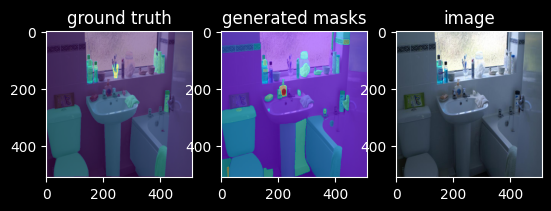

In [5]:

for sample, label, merged_mask in zip(samples, labels, merged_masks):
    fig, axes = plt.subplots(1, 3)
    axes[0].set_title('ground truth')
    show_label(sample, label, ax=axes[0], show=False)
    axes[1].set_title('generated masks')
    show_mask(sample, merged_mask, ax=axes[1], show=False)
    axes[2].set_title('image')
    imshow(sample, ax=axes[2])
    plt.show()

# Where will our point prompts appear?
We show foreground points generated for the mask with background class 0.
Normally, this doesn't make sense, but we do it here because it is simpler than figuring out which
classes are present and usable for point generation

tensor([[[124., 288.]]])


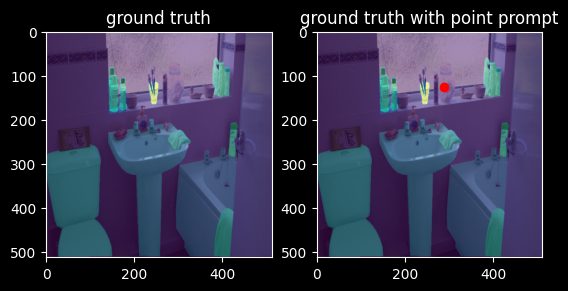

tensor([[[166., 198.]]])


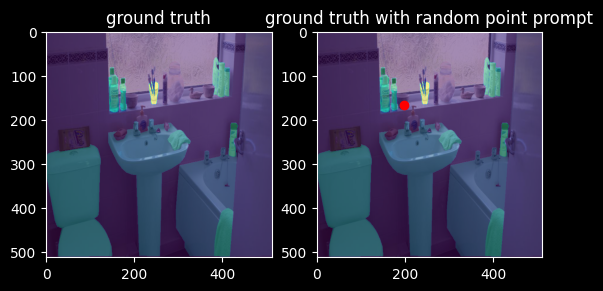

In [7]:
background = 0
points = get_foreground_points((labels == background) * 1)
print(points)
for sample, label, point_list in zip(samples, labels, points):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_title('ground truth')
    show_label(sample, label, ax=axes[0], show=False)
    axes[1].set_title('ground truth with point prompt')
    show_label(sample, label, ax=axes[1], show=False)
    axes[1].scatter([point_list[0][1]], [point_list[0][0]], c='r')
    plt.show()
    
points = get_random_foreground_points((labels == background) * 1)
print(points)
for sample, label, point_list in zip(samples, labels, points):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_title('ground truth')
    show_label(sample, label, ax=axes[0], show=False)
    axes[1].set_title('ground truth with random point prompt')
    show_label(sample, label, ax=axes[1], show=False)
    axes[1].scatter([point_list[0][1]], [point_list[0][0]], c='r')
    plt.show()

# and now for CBIS-Binary

In [8]:
args = Prodict(config='finetune/configs/demo_cbis-binary.yaml', cfg_options={'device': 'cpu'})
cfg = get_cfg(args)
logger = get_logger(cfg)
dataloaders = build_dataloaders(cfg, mask=False)
model = build_model(cfg, logger)
mask_generator = SamAutomaticMaskGenerator(model.model)
samples, labels = next(iter(dataloaders['train']))

{'model': {'optimizer': {'name': 'sgd', 'lr': 0.01, 'wd': 0.0005, 'momentum': 0.9}, 'finetuning': {'name': 'full'}, 'name': 'sam', 'checkpoint': 'checkpoints/sam_vit_b_01ec64.pth', 'backbone': 'vit_b', 'loss': {'reduction': 'mean', 'parts': [{'name': 'Dice', 'weight': 1}, {'name': 'Focal', 'weight': 20}]}, 'metrics': [{'name': 'Dice'}, {'name': 'Focal'}, {'name': 'IoU'}]}, 'device': 'cpu', 'data': {'name': 'cbis-binary', 'root': 'data/cbis/cbis-linked', 'image_extension': '.png', 'annotation_extension': '.png', 'preprocess': [{'name': 'resize', 'dimensions': [512, 512], 'mode': 'bilinear'}], 'train': {'image_dir': 'images/train', 'annotation_dir': 'annotations_binary/train', 'batch_size': 1}, 'val': {'image_dir': 'images/val', 'annotation_dir': 'annotations_binary/val', 'batch_size': 1}, 'test': {'image_dir': 'images/test', 'annotation_dir': 'annotations_binary/test', 'batch_size': 1}}, '_bases_': ['finetune/configs/_base_/datasets/cbis-binary.yaml', 'finetune/configs/_base_/models/sam

/home/drumsnchocolate/miniconda3/envs/segment_anything/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:

merged_masks = [get_mask(repeat(sample, 3), mask_generator) for sample in samples]


(512, 512) (1024, 1024)
6


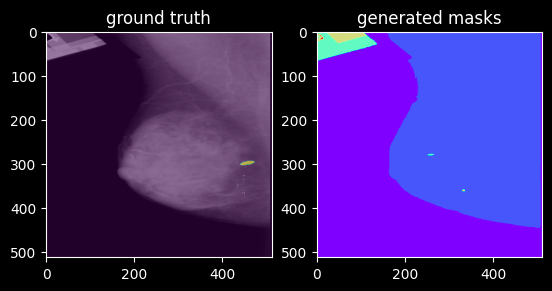

In [10]:
for sample, label, merged_mask in zip(samples, labels, merged_masks):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_title('ground truth')
    show_label(repeat(sample, 3), label, gray_sample=True, ax=axes[0], show=False)
    axes[1].set_title('generated masks')
    # show_mask(sample, merged_mask, ax=axes[1], show=False)
    maskshow(merged_mask, alpha=1, ax=axes[1])
    plt.show()


# Where will our point prompts appear?

tensor([[[298., 458.]]])


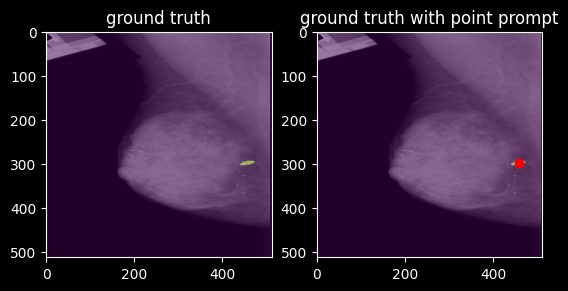

tensor([[[301., 444.]]])


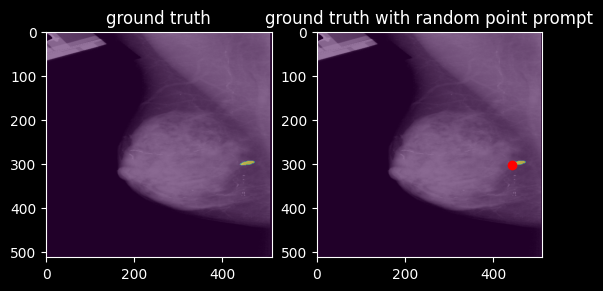

In [11]:
points = get_foreground_points(labels)
print(points)
for sample, label, point_list in zip(samples, labels, points):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_title('ground truth')
    show_label(repeat(sample, 3), label, gray_sample=True, ax=axes[0], show=False)
    axes[1].set_title('ground truth with point prompt')
    show_label(repeat(sample, 3), label, gray_sample=True, ax=axes[1], show=False)
    axes[1].scatter([point_list[0][1]], [point_list[0][0]], c='r')
    plt.show()
    
points = get_random_foreground_points(labels)
print(points)
for sample, label, point_list in zip(samples, labels, points):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_title('ground truth')
    show_label(repeat(sample, 3), label, gray_sample=True, ax=axes[0], show=False)
    axes[1].set_title('ground truth with random point prompt')
    show_label(repeat(sample, 3), label, gray_sample=True, ax=axes[1], show=False)
    axes[1].scatter([point_list[0][1]], [point_list[0][0]], c='r')
    plt.show()

# and now for CBIS-Multi

In [14]:
args = Prodict(config='finetune/configs/demo_cbis-multi.yaml', cfg_options={'device' : 'cpu'})
cfg = get_cfg(args)
dataloaders = build_dataloaders(cfg, mask=False)
model = build_model(cfg)
mask_generator = SamAutomaticMaskGenerator(model)
samples, labels = next(iter(dataloaders['train']))

FileNotFoundError: [Errno 2] No such file or directory: 'finetune/configs/demo_cbis-multi.yaml'

In [ ]:

merged_masks = [get_mask(repeat(sample, 3), mask_generator) for sample in samples]



In [ ]:
for sample, label, merged_mask in zip(samples, labels, merged_masks):
    fig, axes = plt.subplot(1, 2)
    axes[0].set_title('ground truth')
    show_label(repeat(sample, 3), label, gray_sample=True, ax=axes[0])
    axes[1].set_title('generated masks')
    show_mask(sample, merged_mask, ax=axes[1])

In [14]:
get_mask(torch.randint(0,255, (3, 512,412), dtype=torch.uint8), mask_generator)

(512, 412) (1024, 824)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 5.77 GiB total capacity; 4.59 GiB already allocated; 163.25 MiB free; 5.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF